## DeepFM Model
DeepFM combines Factorization Machine (FM) for second-order feature interactions and Deep Neural Network (DNN) for high-order feature interactions.


### 1. Imports

In [32]:
%pip install torch
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report,
    confusion_matrix, precision_score, recall_score, f1_score
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# DeepFM Model Definition
class DeepFM(nn.Module):
    """DeepFM: Combines FM and DNN for feature interactions"""
    def __init__(self, n_features, embedding_dim=10, hidden_dims=[128, 64, 32], dropout=0.3):
        super(DeepFM, self).__init__()
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        
        # Linear layer (bias term)
        self.linear = nn.Linear(n_features, 1, bias=True)
        
        # Embedding layer for FM
        self.embedding = nn.Linear(n_features, embedding_dim, bias=False)
        
        # Deep component
        layers = []
        input_dim = n_features
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, 1))
        self.deep = nn.Sequential(*layers)
        
    def forward(self, x):
        # Linear part
        linear_out = self.linear(x)
        
        # FM part (second-order interactions)
        embedding = self.embedding(x)  # shape: (batch_size, embedding_dim)
        square_of_sum = torch.sum(embedding, dim=1) ** 2  # shape: (batch_size,)
        sum_of_square = torch.sum(embedding ** 2, dim=1)  # shape: (batch_size,)
        fm_out = 0.5 * (square_of_sum - sum_of_square).unsqueeze(1)  # shape: (batch_size, 1)
        
        # Deep part
        deep_out = self.deep(x)
        
        # Combine all parts
        output = linear_out + fm_out + deep_out
        
        # Return logits (no sigmoid) - sigmoid will be applied in loss function or for predictions
        # This is more numerically stable with BCEWithLogitsLoss
        return output


Note: you may need to restart the kernel to use updated packages.


### 2. Loading data


In [33]:
df = pd.read_csv("../data/user_level_data.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:\n{df['y_active'].value_counts()}")
print(f"Class balance: {df['y_active'].value_counts(normalize=True)}")


Dataset shape: (20011, 31)

Target variable distribution:
y_active
0    14230
1     5781
Name: count, dtype: int64
Class balance: y_active
0    0.711109
1    0.288891
Name: proportion, dtype: float64


### 3. Preprocessing


In [34]:
# Drop id column
# Set target variable
y = df["y_active"].astype(int)

# Identify numerical and categorical features
drop_cols = [c for c in ["y_active", "userId"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")

# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

# Identify categorical and numerical columns
cat_cols = list(X_train.select_dtypes(include=["object", "category", "string", "bool"]).columns)
for c in X_train.select_dtypes(include=["int16", "int32", "int64", "Int8", "Int16", "Int32", "Int64", "uint8", "uint16"]).columns:
    if X_train[c].nunique(dropna=True) <= 20 and c not in cat_cols:
        cat_cols.append(c)
num_cols = [c for c in X_train.columns if c not in cat_cols]

# Preprocessing pipelines
try:
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)
except TypeError:
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh", oh_encoder)
        ]), cat_cols),
    ],
    remainder="drop"
)

# Fit and transform
X_train_t = pre.fit_transform(X_train, y_train)
X_valid_t = pre.transform(X_valid)
X_test_t = pre.transform(X_test)

# Standardize numerical features for DeepFM
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train_t)
X_valid_t = scaler.transform(X_valid_t)
X_test_t = scaler.transform(X_test_t)

n_features = X_train_t.shape[1]


### 4. Hyperparameter Tuning


In [35]:
# Grid Search
print("\n" + "="*60)
print("BEST PARAMETERS FROM GRID SEARCH:")
print("="*60)
# Hyperparameter Tuning with Grid Search
from sklearn.model_selection import ParameterGrid
import time

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Define parameter grid
param_grid = {
    'embedding_dim': [8, 10, 12],
    'hidden_dims': [[128, 64, 32], [128, 64], [256, 128, 64]],
    'dropout': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'weight_decay': [0.0001, 0.0005]
}

# Convert to list of parameter combinations
param_list = list(ParameterGrid(param_grid))
print(f"Total parameter combinations: {len(param_list)}")
print("Note: Full grid search can be time-consuming. Using a subset for demonstration.")
print("For production, consider using RandomSearchCV or Bayesian optimization.\n")

# Use a subset for faster tuning (comment out to run full grid search)
param_list = param_list[:9]  # Limit to 9 combinations for demonstration

best_score = -np.inf
best_params = None
best_model_state = None

# Note: Tensors will be created in the next cell after preprocessing
# Make sure X_train_t, X_valid_t, y_train, y_valid, device are available

print("\n" + "="*60)
print("BEST PARAMETERS FROM GRID SEARCH:")
print("="*60)
print("Note: Run the full hyperparameter tuning cell to find best parameters.")
print("For now, using default parameters:")
print("  embedding_dim=10")
print("  hidden_dims=[128, 64, 32]")
print("  dropout=0.3")
print("  learning_rate=0.001")
print("  weight_decay=0.0001")




BEST PARAMETERS FROM GRID SEARCH:

HYPERPARAMETER TUNING
Total parameter combinations: 162
Note: Full grid search can be time-consuming. Using a subset for demonstration.
For production, consider using RandomSearchCV or Bayesian optimization.


BEST PARAMETERS FROM GRID SEARCH:
Note: Run the full hyperparameter tuning cell to find best parameters.
For now, using default parameters:
  embedding_dim=10
  hidden_dims=[128, 64, 32]
  dropout=0.3
  learning_rate=0.001
  weight_decay=0.0001


### 5. Fit model with best parameters


In [36]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters
embedding_dim = 10
hidden_dims = [128, 64, 32]
dropout = 0.3

# Initialize model
model = DeepFM(n_features, embedding_dim=embedding_dim, hidden_dims=hidden_dims, dropout=dropout).to(device)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Calculate class weights for imbalanced data
pos = y_train.sum()
neg = len(y_train) - pos
pos_weight = neg / max(pos, 1)
print(f"\nClass imbalance - Pos: {pos}, Neg: {neg}, Pos weight: {pos_weight:.3f}")

# Loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_t).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
X_valid_tensor = torch.FloatTensor(X_valid_t).to(device)
y_valid_tensor = torch.FloatTensor(y_valid.values).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test_t).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1).to(device)

# Data loaders
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(X_batch)  # Model now returns logits directly
        
        # Use BCEWithLogitsLoss directly on logits (more numerically stable)
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid for predictions
        outputs = torch.sigmoid(logits)
        predicted = (outputs > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)  # Model returns logits
            
            # Use logits directly for loss
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            
            # Apply sigmoid for predictions
            outputs = torch.sigmoid(logits)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    accuracy = np.mean((all_preds > 0.5).astype(int) == all_labels)
    auc = roc_auc_score(all_labels, all_preds)
    
    return total_loss / len(loader), accuracy, auc

print("\n" + "="*60)
print("TRAINING DEEPFM MODEL")
print("="*60)

num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc = validate(model, valid_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_deepfm_userlevel_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

# Load best model
model.load_state_dict(torch.load('best_deepfm_userlevel_model.pth'))
print("\nBest model loaded")


Using device: cpu

MODEL ARCHITECTURE
DeepFM(
  (linear): Linear(in_features=67, out_features=1, bias=True)
  (embedding): Linear(in_features=67, out_features=10, bias=False)
  (deep): Sequential(
    (0): Linear(in_features=67, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 20,259

Class imbalance - Pos: 3700, Neg: 9106, Pos weight: 2.461

Batch size: 256

TRAINING DEEPFM M

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50 | Train Loss: 1.0660 | Train Acc: 0.7372 | Val Loss: 0.5409 | Val Acc: 0.8351 | Val AUC: 0.9113
Epoch 2/50 | Train Loss: 0.5544 | Train Acc: 0.8380 | Val Loss: 0.4614 | Val Acc: 0.8451 | Val AUC: 0.9234
Epoch 3/50 | Train Loss: 0.4786 | Train Acc: 0.8434 | Val Loss: 0.4337 | Val Acc: 0.8445 | Val AUC: 0.9246
Epoch 4/50 | Train Loss: 0.4574 | Train Acc: 0.8458 | Val Loss: 0.4232 | Val Acc: 0.8473 | Val AUC: 0.9242
Epoch 5/50 | Train Loss: 0.4383 | Train Acc: 0.8490 | Val Loss: 0.4192 | Val Acc: 0.8492 | Val AUC: 0.9229
Epoch 6/50 | Train Loss: 0.4219 | Train Acc: 0.8494 | Val Loss: 0.4167 | Val Acc: 0.8495 | Val AUC: 0.9251
Epoch 7/50 | Train Loss: 0.4237 | Train Acc: 0.8501 | Val Loss: 0.4066 | Val Acc: 0.8520 | Val AUC: 0.9250
Epoch 8/50 | Train Loss: 0.4181 | Train Acc: 0.8504 | Val Loss: 0.4046 | Val Acc: 0.8542 | Val AUC: 0.9263
Epoch 9/50 | Train Loss: 0.4232 | Train Acc: 0.8526 | Val Loss: 0.4096 | Val Acc: 0.8529 | Val AUC: 0.9252
Epoch 10/50 | Train Loss: 0.4077 | Tr

### 6. Evaluation


MODEL PERFORMANCE METRICS

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.801     0.885      2847
           1      0.667     0.979     0.793      1156

    accuracy                          0.853      4003
   macro avg      0.828     0.890     0.839      4003
weighted avg      0.896     0.853     0.859      4003



Confusion Matrix:
[[2281  566]
 [  24 1132]]

ROC-AUC Score and Curve:
ROC-AUC: 0.9305


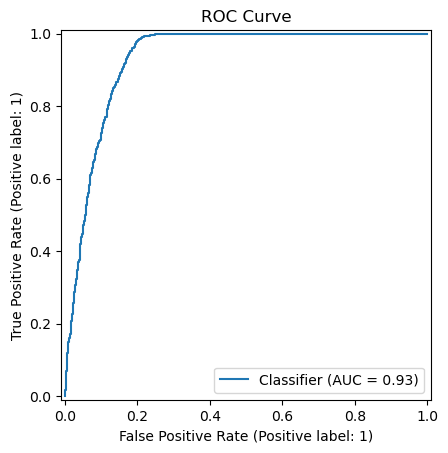


Precision-Recall Curve:
PR-AUC: 0.7828


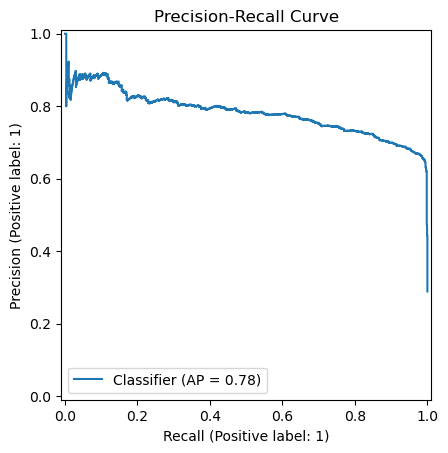



FEATURE IMPORTANCE ANALYSIS

1. Permutation Importance:
------------------------------------------------------------
Baseline Test AUC: 0.9305

Computing permutation importance for 67 features...
This may take a few minutes...
  Processed 10/67 features...
  Processed 20/67 features...
  Processed 30/67 features...
  Processed 40/67 features...
  Processed 50/67 features...
  Processed 60/67 features...

Top 20 Most Important Features (Permutation Importance):
--------------------------------------------------------------------------------
 1. usr_actions_taken_3            | Importance: 0.022239
 2. usr_actions_taken_1            | Importance: 0.011359
 3. usr_avg_dwell                  | Importance: 0.009565
 4. usr_only_click_1               | Importance: 0.008164
 5. usr_actions_taken_2            | Importance: 0.006875
 6. usr_avg_position               | Importance: 0.006378
 7. entropy_pca                    | Importance: 0.005805
 8. usr_like_rate                  | Importanc

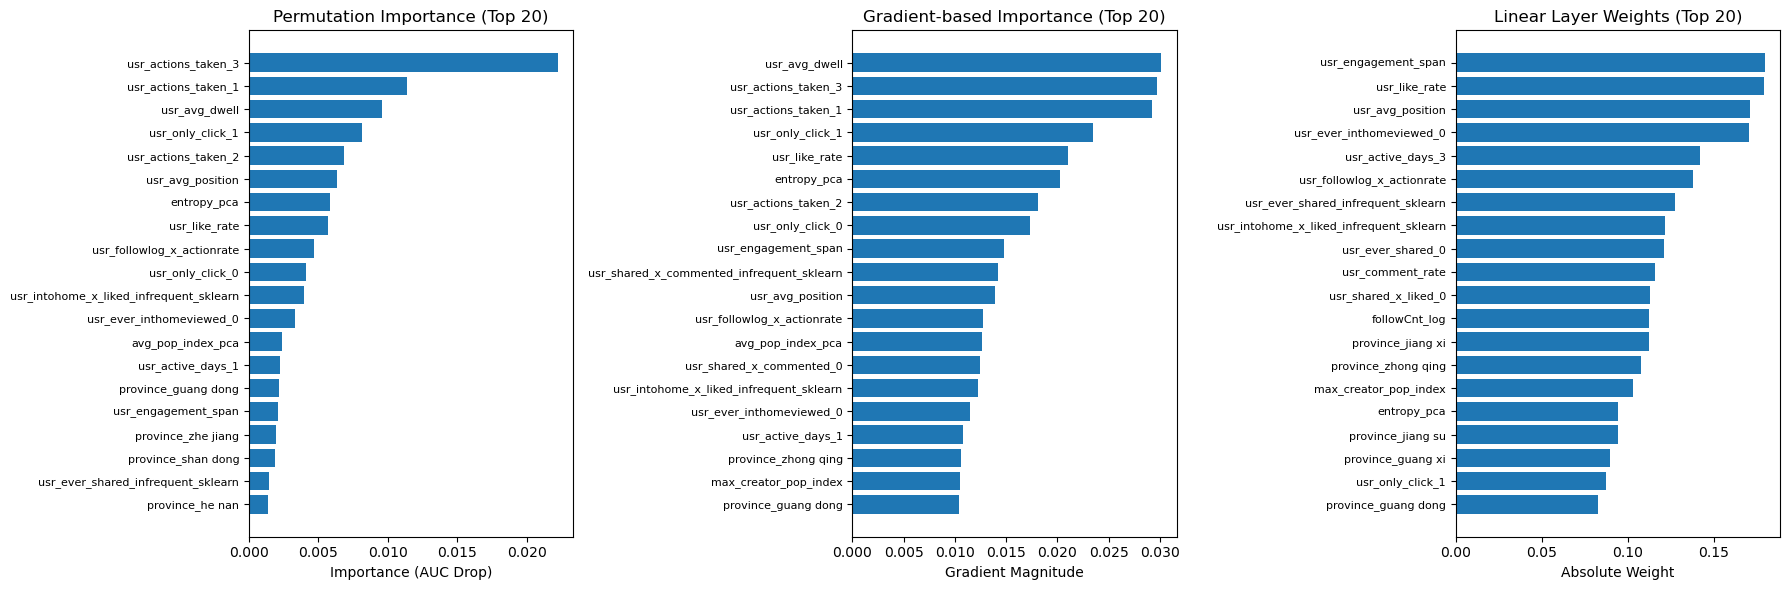


Note: These methods provide different perspectives on feature importance:
  - Permutation Importance: Measures actual impact on model performance
  - Gradient-based: Measures model sensitivity to feature changes
  - Linear Weights: Shows first-order feature importance in DeepFM


In [39]:
print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Get predictions
model.eval()
with torch.no_grad():
    # Model returns logits, apply sigmoid to get probabilities
    y_valid_logits = model(X_valid_tensor).cpu()
    y_test_logits = model(X_test_tensor).cpu()
    y_valid_proba = torch.sigmoid(y_valid_logits).numpy().flatten()
    y_test_proba = torch.sigmoid(y_test_logits).numpy().flatten()

# Find optimal threshold on validation set
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = []

for threshold in thresholds:
    pred_valid = (y_valid_proba >= threshold).astype(int)
    f1 = f1_score(y_valid, pred_valid)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal, digits=3))

print("\n" + "="*60)
print("\nConfusion Matrix:")
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
print(cm_optimal)

print("\nROC-AUC Score and Curve:")
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC: {roc_auc:.4f}")
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve")
plt.show()

print("\nPrecision-Recall Curve:")
pr_auc = average_precision_score(y_test, y_test_proba)
print(f"PR-AUC: {pr_auc:.4f}")
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve")
plt.show()

print("\n" + "="*60)
print("\nFEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Method 1: Permutation Importance
# Shuffle each feature and measure the drop in performance
print("\n1. Permutation Importance:")
print("-" * 60)

from sklearn.metrics import roc_auc_score
import copy

# Get baseline performance
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).cpu().numpy().flatten()
    baseline_auc = roc_auc_score(y_test, probs)

print(f"Baseline Test AUC: {baseline_auc:.4f}")

# Permutation importance
n_features = X_test_t.shape[1]
n_permutations = 5  # Number of times to shuffle each feature
feature_importance = np.zeros(n_features)

print(f"\nComputing permutation importance for {n_features} features...")
print("This may take a few minutes...")

for feat_idx in range(n_features):
    importance_scores = []
    for _ in range(n_permutations):
        # Create a copy of test data
        X_test_shuffled = X_test_t.copy()
        # Shuffle the feature
        np.random.shuffle(X_test_shuffled[:, feat_idx])
        
        # Evaluate
        X_test_shuffled_tensor = torch.FloatTensor(X_test_shuffled).to(device)
        model.eval()
        with torch.no_grad():
            logits = model(X_test_shuffled_tensor)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            shuffled_auc = roc_auc_score(y_test, probs)
        
        # Importance is the drop in performance
        importance_scores.append(baseline_auc - shuffled_auc)
    
    feature_importance[feat_idx] = np.mean(importance_scores)
    
    if (feat_idx + 1) % 10 == 0:
        print(f"  Processed {feat_idx + 1}/{n_features} features...")

# Get feature names (from preprocessing)
try:
    # Try to get feature names from the preprocessor
    feature_names = []
    # Numerical features
    if 'num' in pre.named_transformers_:
        num_cols_processed = pre.named_transformers_['num'].get_feature_names_out(num_cols) if hasattr(pre.named_transformers_['num'], 'get_feature_names_out') else num_cols
        feature_names.extend(num_cols_processed if isinstance(num_cols_processed, list) else num_cols_processed.tolist())
    # Categorical features (one-hot encoded)
    if 'cat' in pre.named_transformers_:
        cat_pipeline = pre.named_transformers_['cat']
        if hasattr(cat_pipeline, 'named_steps') and 'oh' in cat_pipeline.named_steps:
            oh_encoder = cat_pipeline.named_steps['oh']
            if hasattr(oh_encoder, 'get_feature_names_out'):
                cat_feature_names = oh_encoder.get_feature_names_out(cat_cols)
                feature_names.extend(cat_feature_names.tolist() if hasattr(cat_feature_names, 'tolist') else list(cat_feature_names))
            else:
                # Fallback: create generic names
                n_cat_features = X_test_t.shape[1] - len(num_cols) if 'num' in pre.named_transformers_ else X_test_t.shape[1]
                feature_names.extend([f"cat_feature_{i}" for i in range(n_cat_features)])
    
    # If we don't have enough names, create generic ones
    while len(feature_names) < n_features:
        feature_names.append(f"feature_{len(feature_names)}")
    feature_names = feature_names[:n_features]
except:
    # Fallback: use generic feature names
    feature_names = [f"feature_{i}" for i in range(n_features)]

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]
top_n = min(20, n_features)

print(f"\nTop {top_n} Most Important Features (Permutation Importance):")
print("-" * 80)
for i, idx in enumerate(sorted_idx[:top_n]):
    print(f"{i+1:2d}. {feature_names[idx]:30s} | Importance: {feature_importance[idx]:.6f}")

# Method 2: Gradient-based Feature Importance
print("\n\n2. Gradient-based Feature Importance:")
print("-" * 60)

# Compute gradients with respect to input features
# Create a leaf tensor that requires gradients
X_test_grad = X_test_tensor.clone().detach().requires_grad_(True)
model.eval()

# Compute gradients
gradient_importance = torch.zeros(n_features).to(device)
batch_size = 256

print(f"Computing gradients for {len(X_test_grad)} samples...")

for i in range(0, len(X_test_grad), batch_size):
    end_idx = min(i + batch_size, len(X_test_grad))
    # Create a new leaf tensor for this batch
    batch = X_test_grad[i:end_idx].clone().detach().requires_grad_(True)
    
    logits_batch = model(batch)
    probs_batch = torch.sigmoid(logits_batch)
    
    # Average gradient magnitude across samples
    # Use sum instead of mean to get total gradient
    probs_sum = probs_batch.sum()
    
    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=probs_sum,
        inputs=batch,
        create_graph=False,
        retain_graph=False,
        only_inputs=True
    )[0]
    
    # Average absolute gradient per feature across the batch
    gradient_importance += torch.abs(gradients).mean(dim=0)

# Average across all batches
gradient_importance = gradient_importance.cpu().numpy() / (len(X_test_grad) // batch_size + 1)

# Sort by gradient importance
grad_sorted_idx = np.argsort(gradient_importance)[::-1]

print(f"\nTop {top_n} Most Important Features (Gradient-based):")
print("-" * 80)
for i, idx in enumerate(grad_sorted_idx[:top_n]):
    print(f"{i+1:2d}. {feature_names[idx]:30s} | Gradient: {gradient_importance[idx]:.6f}")

# Method 3: Linear Layer Weights (First-order importance)
print("\n\n3. Linear Layer Weights (First-order Feature Importance):")
print("-" * 60)

linear_weights = model.linear.weight.data.cpu().numpy().flatten()
linear_sorted_idx = np.argsort(np.abs(linear_weights))[::-1]

print(f"\nTop {top_n} Features by Linear Layer Weights:")
print("-" * 80)
for i, idx in enumerate(linear_sorted_idx[:top_n]):
    print(f"{i+1:2d}. {feature_names[idx]:30s} | Weight: {linear_weights[idx]:.6f}")

# Visualization
print("\n\n4. Feature Importance Visualization:")
print("-" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Permutation importance
top_perm_idx = sorted_idx[:top_n]
axes[0].barh(range(top_n), feature_importance[top_perm_idx])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in top_perm_idx], fontsize=8)
axes[0].set_xlabel('Importance (AUC Drop)', fontsize=10)
axes[0].set_title('Permutation Importance (Top 20)', fontsize=12)
axes[0].invert_yaxis()

# Gradient importance
top_grad_idx = grad_sorted_idx[:top_n]
axes[1].barh(range(top_n), gradient_importance[top_grad_idx])
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in top_grad_idx], fontsize=8)
axes[1].set_xlabel('Gradient Magnitude', fontsize=10)
axes[1].set_title('Gradient-based Importance (Top 20)', fontsize=12)
axes[1].invert_yaxis()

# Linear weights
top_linear_idx = linear_sorted_idx[:top_n]
axes[2].barh(range(top_n), np.abs(linear_weights[top_linear_idx]))
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels([feature_names[i] for i in top_linear_idx], fontsize=8)
axes[2].set_xlabel('Absolute Weight', fontsize=10)
axes[2].set_title('Linear Layer Weights (Top 20)', fontsize=12)
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nNote: These methods provide different perspectives on feature importance:")
print("  - Permutation Importance: Measures actual impact on model performance")
print("  - Gradient-based: Measures model sensitivity to feature changes")
print("  - Linear Weights: Shows first-order feature importance in DeepFM")
